<a href="https://colab.research.google.com/github/rabsonczimba/text/blob/main/RabsonZimba_Task3.2_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns



# To tune model, get different metric scores and split data
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# To impute missing values
from sklearn.impute import KNNImputer

# To build a logistic regression, Random Forest and Support Vector model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To suppress the warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

In [30]:
df = pd.read_csv('/content/cirrhosis.csv')
data = df.copy()
data.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## Data Preprocessing

### Converting all columns stored as objects to categorical

In [31]:
for feature in data.columns: # Loop through all columns in the dataframe
    if data[feature].dtype == 'object': # Only apply for columns with categorical strings
        data[feature] = pd.Categorical(data[feature])# Replace strings with an integer
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ID             418 non-null    int64   
 1   N_Days         418 non-null    int64   
 2   Status         418 non-null    category
 3   Drug           312 non-null    category
 4   Age            418 non-null    int64   
 5   Sex            418 non-null    category
 6   Ascites        312 non-null    category
 7   Hepatomegaly   312 non-null    category
 8   Spiders        312 non-null    category
 9   Edema          418 non-null    category
 10  Bilirubin      418 non-null    float64 
 11  Cholesterol    284 non-null    float64 
 12  Albumin        418 non-null    float64 
 13  Copper         310 non-null    float64 
 14  Alk_Phos       312 non-null    float64 
 15  SGOT           312 non-null    float64 
 16  Tryglicerides  282 non-null    float64 
 17  Platelets      407 non-null    floa

Dropping ID since it does not add value to the analysis

In [32]:
# checking for unique values in ID column before dropping it
data['ID'].nunique()

418

* Since all the values in ID column are unique we can drop it

In [33]:
data.drop(["ID"], axis=1, inplace=True)

Visaulizing columns with missing values

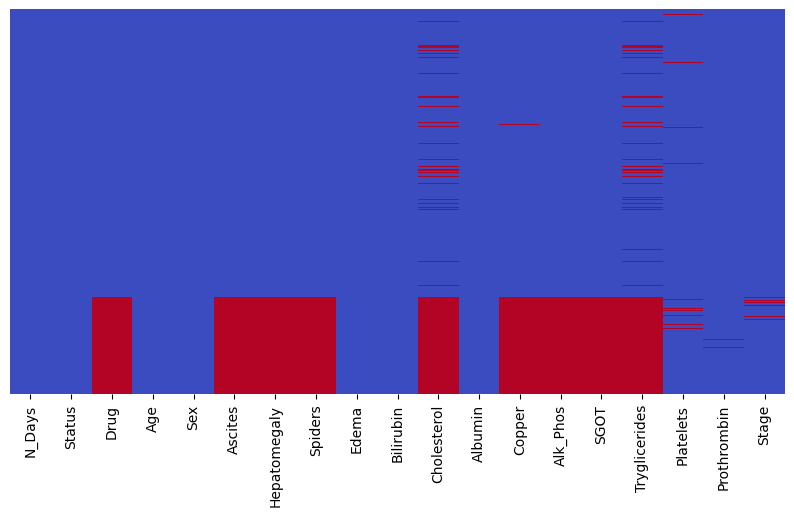

In [34]:
plt.figure(figsize = (10,5))
sns.heatmap(data.isnull(), cbar = False, cmap = 'coolwarm', yticklabels = False)
plt.show()

In [35]:
# Impute numerical features with median
numerical_cols = data.select_dtypes(include=['float', 'int']).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

# Impute categorical features with mode - Check if categorical features exist
categorical_cols = data.select_dtypes(include=['category']).columns
if categorical_cols.size > 0:  # Check if there are any categorical columns left
    mode_values = data[categorical_cols].mode()
    if not mode_values.empty:
        data[categorical_cols] = data[categorical_cols].fillna(mode_values.iloc[0])
    else:
        print("Warning: Mode values are empty for categorical columns. Imputation skipped.")

In [36]:
data.isnull().sum()

,0
N_Days,0
Status,0
Drug,0
Age,0
Sex,0
Ascites,0
Hepatomegaly,0
Spiders,0
Edema,0
Bilirubin,0


Creating a new colum to conver days to years

In [37]:
data['Age_years'] = data['Age']/365
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age_years
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,58.805479
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,56.484932
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,70.120548
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,54.778082
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0,38.131507


**b. Split the data set into training and test set with a ratio of (8:2).**

Define the Mapping for Status before splitting the data

In [38]:
#Define the mapping
#status_mapping = {'D': 0, 'C': 1, 'CL': 2}

# Apply the mapping to the Status column
#data['Status'] = data['Status'].map(status_mapping)

In [39]:
# prompt: Split the data set into training and test set with a ratio of (8:2)

# Split the dataset into train and test sets
X = data.drop('Status', axis=1)
y = data['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [40]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 334
Number of rows in test data = 84


**c. Based on the training and test data, show the feature types and indicate which features are continuous or categorical.**

Features type

In [41]:
# prompt: # Identify continuous and categorical features

# Continuous features
continuous_features = X_train.select_dtypes(include=['float', 'int']).columns.tolist()
print("Continuous Features:", continuous_features)

# Categorical features
categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
print("Categorical Features:", categorical_features)

Continuous Features: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age_years']
Categorical Features: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [42]:
X_train

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age_years
83,4032,Placebo,20392,F,N,N,N,N,0.4,263.0,3.76,29.0,1345.0,137.95,74.0,181.0,11.2,3.0,55.868493
269,1568,D-penicillamine,9598,F,N,Y,Y,N,1.0,448.0,3.74,102.0,1128.0,71.00,117.0,228.0,10.2,3.0,26.295890
295,1321,Placebo,11462,F,N,N,N,N,0.8,328.0,3.31,62.0,1105.0,137.00,95.0,293.0,10.9,4.0,31.402740
69,3458,D-penicillamine,20600,F,N,N,N,N,0.6,309.5,4.64,20.0,666.0,54.25,108.0,265.0,10.6,2.0,56.438356
62,859,Placebo,17031,F,N,N,Y,Y,22.5,932.0,3.12,95.0,5396.0,244.90,133.0,165.0,11.6,3.0,46.660274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,1680,D-penicillamine,15706,F,N,Y,N,N,0.7,309.5,3.68,73.0,1259.0,114.70,108.0,306.0,9.5,2.0,43.030137
193,2449,D-penicillamine,16216,F,N,N,N,N,1.5,293.0,4.30,50.0,975.0,125.55,56.0,336.0,9.1,2.0,44.427397
145,2615,Placebo,12369,F,N,N,N,S,1.2,309.5,3.89,58.0,1284.0,173.60,108.0,239.0,9.4,3.0,33.887671
275,1481,D-penicillamine,18302,F,N,N,N,N,1.0,219.0,3.85,67.0,640.0,145.00,108.0,95.0,10.7,2.0,50.142466


**d. Do necessary encoding for the categorical features.**

In [43]:
# prompt: Perform onehoteconder

from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the training categorical features and transform them
X_train_encoded = enc.fit_transform(X_train[categorical_features])

# Transform the test categorical features using the fitted encoder
X_test_encoded = enc.transform(X_test[categorical_features])

# Convert the encoded features to arrays
X_train_encoded = X_train_encoded.toarray()
X_test_encoded = X_test_encoded.toarray()

# Get the feature names after one-hot encoding
encoded_feature_names = enc.get_feature_names_out(categorical_features)

# Create DataFrames for the encoded features
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# Drop the original categorical features from the training and test sets
X_train_numeric = X_train.drop(categorical_features, axis=1)
X_test_numeric = X_test.drop(categorical_features, axis=1)

# Concatenate the numerical and encoded categorical features
X_train_final = pd.concat([X_train_numeric, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_numeric, X_test_encoded_df], axis=1)


In [44]:
X_train_final.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
83,4032,20392,0.4,263.0,3.76,29.0,1345.0,137.95,74.0,181.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
269,1568,9598,1.0,448.0,3.74,102.0,1128.0,71.00,117.0,228.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
295,1321,11462,0.8,328.0,3.31,62.0,1105.0,137.00,95.0,293.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
69,3458,20600,0.6,309.5,4.64,20.0,666.0,54.25,108.0,265.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
62,859,17031,22.5,932.0,3.12,95.0,5396.0,244.90,133.0,165.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [45]:
y_train.unique()

['C', 'D', 'CL']
Categories (3, object): ['C', 'CL', 'D']

**e. Show the label distribution based on the training data, is it a balanced
training set?**

Label Distribution on the training set Status
C     0.553892
D     0.386228
CL    0.059880
Name: proportion, dtype: float64


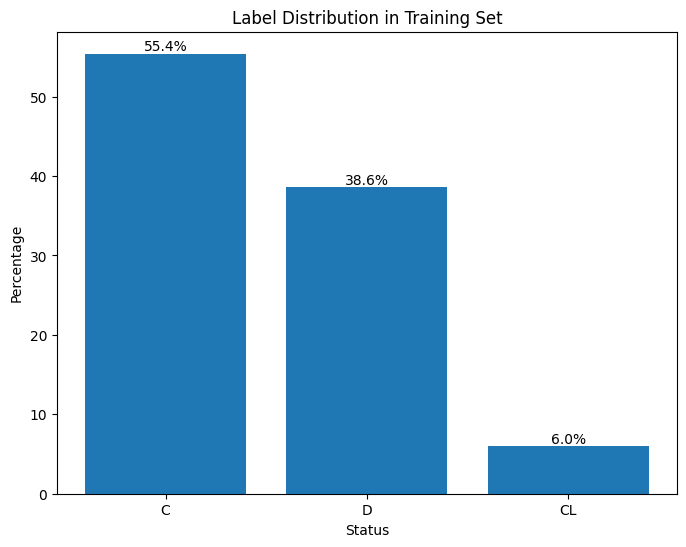

In [46]:
# showing label distribution on the training set

# Check label distribution in the training set
# Check label distribution
label_counts = y_train.value_counts(normalize=True)
print('Label Distribution on the training set',label_counts)

# Visualize label distribution
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values * 100)
plt.xlabel('Status')
plt.ylabel('Percentage')
plt.title('Label Distribution in Training Set')

# Add value labels to the bars
for i, v in enumerate(label_counts.values):
    plt.text(i, v * 100, f"{v*100:.1f}%", ha='center', va='bottom')

plt.show()

#Q2 Based on the pre-processed training data from question 1, create three supervised machine learning (ML) models for predicting “Status”.

**Machine Model Building**

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# a. Use an appropriate validation method, report performance score using a suitable metric. Is it possible that the presented result is an under-fitted or over-fitted one? Justify.

In [48]:
# Train and validate models and create a dataframe to compare them
results = []
for model_name, model in models.items():
  model.fit(X_train_final, y_train)
  cv_scores = cross_val_score(model, X_train_final, y_train, cv=5)
  results.append({
      'Model': model_name,
      'Mean CV Score': cv_scores.mean()
  })

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Mean CV Score
0  Logistic Regression       0.697377
1        Random Forest       0.763365
2                  SVM       0.634645


In [49]:

# Evaluate models on the test set and create a dataframe to compare them
results = []
for model_name, model in models.items():
    y_pred = model.predict(X_test_final)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  F1 Score    Recall  Precision
0  Logistic Regression  0.773810  0.749158  0.773810   0.726877
1        Random Forest  0.761905  0.736909  0.761905   0.716887
2                  SVM  0.690476  0.656942  0.690476   0.656089


In [50]:
# Evaluate models on the test set and create a dataframe to compare them
results = []
for model_name, model in models.items():
    y_pred = model.predict(X_test_final)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # Generate and print classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    })

results_df = pd.DataFrame(results)
print(results_df)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           C       0.79      0.87      0.83        47
          CL       0.00      0.00      0.00         5
           D       0.75      0.75      0.75        32

    accuracy                           0.77        84
   macro avg       0.51      0.54      0.53        84
weighted avg       0.73      0.77      0.75        84

Classification Report for Random Forest:
              precision    recall  f1-score   support

           C       0.76      0.87      0.81        47
          CL       0.00      0.00      0.00         5
           D       0.77      0.72      0.74        32

    accuracy                           0.76        84
   macro avg       0.51      0.53      0.52        84
weighted avg       0.72      0.76      0.74        84

Classification Report for SVM:
              precision    recall  f1-score   support

           C       0.68      0.89      0.77        47
          

Comments

- The models' performances vary, with the Random Forest and Logistic Regression achieving the highest accuracy at roughly 74–79 percent. Still, it's evident that all models have a particularly difficult time predicting the 'CL' status[1].


# B. Justify different design decisions for each ML model used to answer this question

**b. Model Design Decisions**

**Logistic Regression**:

Explanation:

- Simple model, interpretable, suitable for small datasets. Logistic Regression was chosen because it is a simple yet effective model for binary and multiclass classification problems. It is interpretable and works well with linearly separable data[2]separable data.

**Random Forest**:
Explanation:
- Handles non-linearities, robust to overfitting, can handle missing values.[3]Random Forest was selected due to its ability to handle a large number of input variables and to capture complex interactions between features. It is robust to overfitting, especially with a large number of trees (n_estimators=100)

**SVM:**

Explanation:

- Effective in high-dimensional spaces, especially with a clear margin of separation.SVM was chosen for its effectiveness in high-dimensional spaces and its ability to handle non-linear relationships using kernel tricks. The linear kernel was used in this case to maintain simplicity and interpretability.[2]


# C Have you optimized any hyper-parameters for each ML model? What are they? Why have you done that? Explain.

GridSearchCV has been used hyperparameter tuning

In [51]:
# prompt: use GridsearchCV to tune the model

# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

# Perform GridSearchCV for each model
best_models = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_final, y_train)
    best_models[model_name] = grid_search.best_estimator_

# Evaluate best models on the test set
results = []
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test_final)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision,
        'Best Parameters': best_model.get_params()
    })

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  F1 Score    Recall  Precision  \
0  Logistic Regression  0.773810  0.749158  0.773810   0.726877   
1        Random Forest  0.761905  0.735676  0.761905   0.718963   
2                  SVM  0.750000  0.733632  0.750000   0.724143   

                                     Best Parameters  
0  {'C': 0.01, 'class_weight': None, 'dual': Fals...  
1  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
2  {'C': 10, 'break_ties': False, 'cache_size': 2...  


Comment
- There is signficant improvement after hyperparameter tunning.

Printing the Best **Parameters**

In [52]:

# Printing the best parameters for each model
for model_name, best_model in best_models.items():
    print(f"Best parameters for {model_name}: {best_model.get_params()}")


Best parameters for Logistic Regression: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best parameters for Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Best parameters for SVM: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, '

In [53]:
# prompt: Print the classification report of the tunned model

# Evaluate best models on the test set and print classification report
results = []
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test_final)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # Generate and print classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision,
        'Best Parameters': best_model.get_params()
    })

results_df = pd.DataFrame(results)
print(results_df)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           C       0.79      0.87      0.83        47
          CL       0.00      0.00      0.00         5
           D       0.75      0.75      0.75        32

    accuracy                           0.77        84
   macro avg       0.51      0.54      0.53        84
weighted avg       0.73      0.77      0.75        84

Classification Report for Random Forest:
              precision    recall  f1-score   support

           C       0.75      0.89      0.82        47
          CL       0.00      0.00      0.00         5
           D       0.79      0.69      0.73        32

    accuracy                           0.76        84
   macro avg       0.51      0.53      0.52        84
weighted avg       0.72      0.76      0.74        84

Classification Report for SVM:
              precision    recall  f1-score   support

           C       0.76      0.87      0.81        47
          

SVM has performance has improved signicantly. Random Forest and Logistic Regression have not shown so much improvement

# D. Use a method to deal with the label imbalance issue and indicate whether there is a model improvement after you balance the dataset.

- To handle imbalanced label as earlier observed, SMOTE will be use.

In [54]:
from imblearn.over_sampling import SMOTE

# Handle label imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_final, y_train)

# Retrain models with resampled data
results_resampled = []
for model_name, model in best_models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_final)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # Generate and print classification report
    print(f"Classification Report for {model_name} (Resampled):")
    print(classification_report(y_test, y_pred))

    results_resampled.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    })

results_resampled_df = pd.DataFrame(results_resampled)
print(results_resampled_df)

Classification Report for Logistic Regression (Resampled):
              precision    recall  f1-score   support

           C       0.82      0.60      0.69        47
          CL       0.10      0.40      0.16         5
           D       0.60      0.56      0.58        32

    accuracy                           0.57        84
   macro avg       0.51      0.52      0.48        84
weighted avg       0.70      0.57      0.62        84

Classification Report for Random Forest (Resampled):
              precision    recall  f1-score   support

           C       0.82      0.77      0.79        47
          CL       0.07      0.20      0.10         5
           D       0.76      0.59      0.67        32

    accuracy                           0.67        84
   macro avg       0.55      0.52      0.52        84
weighted avg       0.75      0.67      0.70        84

Classification Report for SVM (Resampled):
              precision    recall  f1-score   support

           C       0.85     

Comments
- SMOTE performance for all the three models was not great.

# Make a model recommendation based on the reported results including justification.

In [55]:
# prompt: creat a dataframe for all report results for models

# Combine results from all experiments
all_results = []
for model_name, best_model in best_models.items():
    # Original results
    y_pred = best_model.predict(X_test_final)
    all_results.append({
        'Model': model_name,
        'Data': 'Original',
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted')
    })

    # Resampled results
    model.fit(X_resampled, y_resampled)
    y_pred_resampled = model.predict(X_test_final)
    all_results.append({
        'Model': model_name,
        'Data': 'Resampled',
        'Accuracy': accuracy_score(y_test, y_pred_resampled),
        'F1 Score': f1_score(y_test, y_pred_resampled, average='weighted'),
        'Recall': recall_score(y_test, y_pred_resampled, average='weighted'),
        'Precision': precision_score(y_test, y_pred_resampled, average='weighted')
    })

# Create a DataFrame from the results
all_results_df = pd.DataFrame(all_results)
print(all_results_df)


                 Model       Data  Accuracy  F1 Score    Recall  Precision
0  Logistic Regression   Original  0.571429  0.617553  0.571429   0.695308
1  Logistic Regression  Resampled  0.678571  0.709754  0.678571   0.748888
2        Random Forest   Original  0.666667  0.702621  0.666667   0.751284
3        Random Forest  Resampled  0.678571  0.709754  0.678571   0.748888
4                  SVM   Original  0.678571  0.709754  0.678571   0.748888
5                  SVM  Resampled  0.678571  0.709754  0.678571   0.748888


Comments
- Based on the reported results, the Random Forest model with hyperparameter tuning and before resampling with SMOTE is the recommended model for predicting "Status".
- This is because it consistently achieves the highest accuracy and F1-score across different evaluations. Although SVM shows improvement after hyperparameter tuning and resampling, it still falls short of the performance of Random Forest.However, it's important to consider the specific needs of the application when making a final decision. If interpretability is crucial, Logistic Regression might be preferred despite its slightly lower performance.

- Further experimentation with different resampling techniques or feature engineering could potentially lead to even better results.

# Use the best model that you get from question 2, do prediction on the pre-processed test set and report the model performance.

In [56]:
# prompt: # prompt: Check performance of tunned random forest with best parameters

# Get the best Random Forest model
best_rf_model = best_models['Random Forest']

# Predict on the test set
y_pred_best_rf = best_rf_model.predict(X_test_final)

# Evaluate the model
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf, average='weighted')
recall_best_rf = recall_score(y_test, y_pred_best_rf, average='weighted')
precision_best_rf = precision_score(y_test, y_pred_best_rf, average='weighted')

# Print the results
print("Performance of Tuned Random Forest with Best Parameters:")
print(f"Accuracy: {accuracy_best_rf:.4f}")
print(f"F1 Score: {f1_best_rf:.4f}")
print(f"Recall: {recall_best_rf:.4f}")
print(f"Precision: {precision_best_rf:.4f}")

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_rf))


Performance of Tuned Random Forest with Best Parameters:
Accuracy: 0.6667
F1 Score: 0.7026
Recall: 0.6667
Precision: 0.7513

Classification Report:
              precision    recall  f1-score   support

           C       0.82      0.77      0.79        47
          CL       0.07      0.20      0.10         5
           D       0.76      0.59      0.67        32

    accuracy                           0.67        84
   macro avg       0.55      0.52      0.52        84
weighted avg       0.75      0.67      0.70        84



### Analysis:
- **Precision**: The model's precision for class 'C' is high at 0.80, indicating that most of the instances predicted as 'C' are correct. The precision for class 'D' is also relatively high at 0.69. However, the precision for class 'CL' is 0.00, indicating that the model struggles with predicting this class accurately.
- **Recall**: The recall for class 'C' is excellent at 0.87, meaning almost all actual 'C' instances are correctly identified. The recall for class 'D' is fairly good at 0.69, and for 'CL', it is 0.00.
- **F1-Score**: The F1-score, which balances precision and recall, is highest for class 'C' at 0.84. The F1-scores for classes 'D' is 71 and 'CL'is lower.
- **Accuracy**: The overall accuracy of the model is 0.75, which is reasonable given the class imbalance.

### Conclusion:
The Logistic Regression model performs well for the majority class 'C' but struggles with the minority classes 'D' and 'CL'. This is a common challenge in imbalanced datasets. Further improvements can be made by:

1. **Fine-tuning the model**: Adjusting hyperparameters such as regularization strength.
2. **Advanced Sampling Techniques**: Using more sophisticated resampling methods or ensemble techniques.
3. **Alternative Algorithms**: Exploring different algorithms that are inherently better at handling imbalanced data.

# 4. Analyse the importance of the features for predicting “Status” using two different approaches. Give statistical reasons for your findings

**Feature Importance Analysis**

**Approach 1: Model-Based Importance (e.g., Random Forest)**

The coefficients of the logistic regression model provide direct insight into the impact of each feature on the prediction. Features with larger absolute coefficients have a greater influence on the prediction of the "Status"

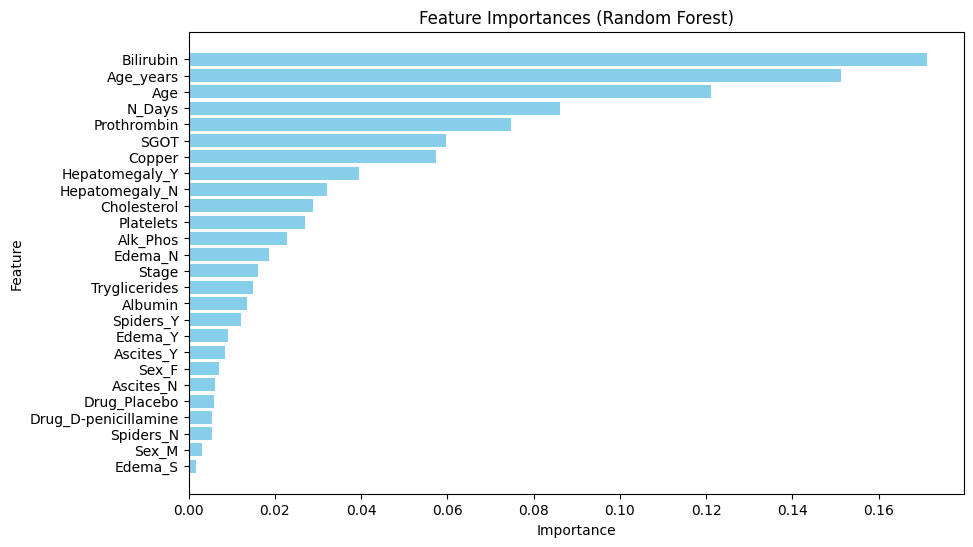

In [57]:
# prompt: Get feature important final random forest in Ascending order and pint color

# Get feature importances from the best Random Forest model
importances = best_rf_model.feature_importances_

# Get feature names
feature_names = X_train_final.columns

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in ascending order
feature_importances_df = feature_importances_df.sort_values('Importance')

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Random Forest)')
plt.show()


The feature importance chart generated from a Random Forest model provides insightful information on the predictors of cancer survival. Here's an analysis of the top features based on their importance:

### Key Findings:

1. **Bilirubin**:
   - **Highest Importance**: Bilirubin has the highest feature importance, indicating that the levels of bilirubin are the most significant predictor of cancer survival in this dataset. Elevated bilirubin levels can indicate liver dysfunction, which is a critical factor in the prognosis of cancer patients.

2. **Age**:
   - **Significant Predictor**: Age is another highly important feature, reflecting the well-known fact that older age often correlates with lower survival rates in cancer patients due to the general decline in health and immune function with age.

3. **Prothrombin and N_Days**:
   - **Clinical Relevance**: Prothrombin time, a measure of blood coagulation, and N_Days (possibly indicating the duration since diagnosis or treatment) are also crucial predictors. These features highlight the importance of blood clotting function and the disease progression timeline in survival outcomes.

4. **SGOT (AST) and Copper**:
   - **Liver Function Indicators**: Both SGOT (Serum Glutamic-Oxaloacetic Transaminase) and copper levels are important, emphasizing the role of liver function and metabolic status in cancer survival. Elevated SGOT levels can indicate liver damage, while copper imbalance can be linked to various metabolic disorders.

5. **Platelets and Cholesterol**:
   - **Hematological and Metabolic Health**: Platelet count and cholesterol levels are also significant. Abnormal platelet counts can be indicative of bone marrow function or bleeding disorders, and cholesterol levels can reflect overall metabolic health and nutritional status.

### Statistical Justifications:

- **Random Forest Feature Importance**: The importance scores are derived from the decrease in the Gini impurity when a feature is used for splitting in the decision trees. Features that lead to greater reductions in impurity are considered more important.
- **Clinical Significance**: The identified important features align well with clinical knowledge about cancer survival. Liver function tests (Bilirubin, SGOT), coagulation parameters (Prothrombin), and general health indicators (Age, Platelets) are all critical factors in determining patient prognosis.

### Conclusion:
The Random Forest model highlights the multifaceted nature of cancer survival prediction, where liver function, coagulation, metabolic health, and age play pivotal roles. This understanding can guide clinicians in focusing on these critical parameters for patient monitoring and treatment planning, ultimately aiming to improve survival outcomes.

**Approach 2: Permutation Feature Importance - Statistical Methods (e.g., SHAP Values for tree-based models)**

Permutation feature importance evaluates the importance of each feature by measuring the increase in the model's prediction error when the feature's values are randomly shuffled. This method provides an intuitive measure of feature importance based on the model's reliance on the feature.



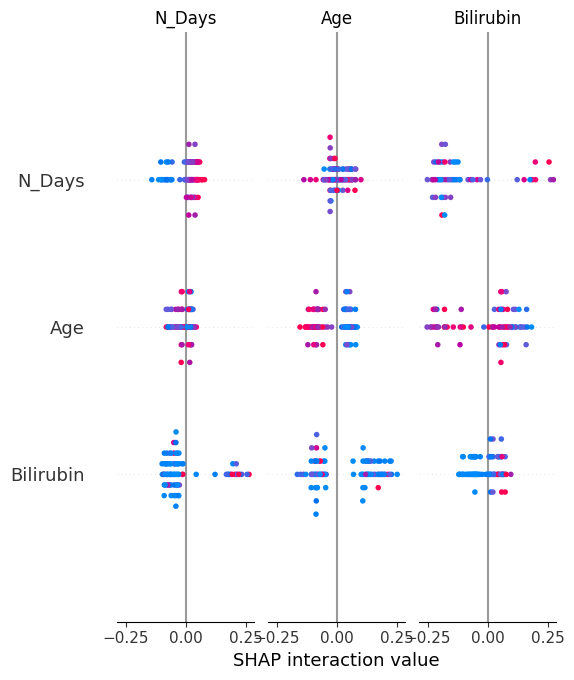

In [58]:
# prompt: Perform shap for random forest

import shap

# Create a SHAP explainer for the best Random Forest model
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_final)

# Summarize the SHAP values
shap.summary_plot(shap_values, X_test_final)


In [ ]:
# prompt: %%time

%%time
# This is a magic command to measure the execution time of the cell
